# Initial Tests

In [13]:
import powerbox as pbox
import matplotlib.pyplot as plt
import numpy as np

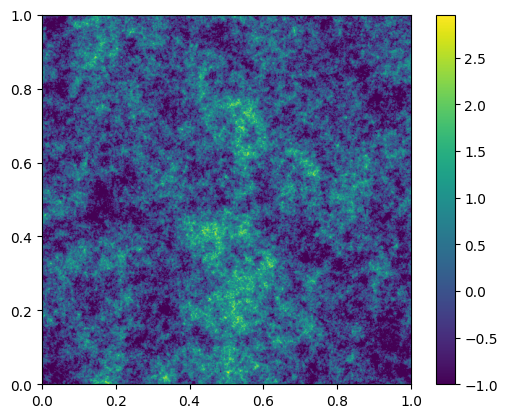

In [14]:
pb = pbox.PowerBox(
    N=512,                     # Number of grid-points in the box
    dim=2,                     # 2D box
    pk = lambda k: 0.5*k**-2., # The power-spectrum
    boxlength = 1.0,           # Size of the box (sets the units of k in pk)
    seed = 1010,               # Set a seed to ensure the box looks the same every time (optional)
    ensure_physical=True       # ** Ensure the delta_x is a physically valid over-density **
)


plt.imshow(pb.delta_x(),extent=(0,1,0,1))
plt.colorbar()
plt.show()

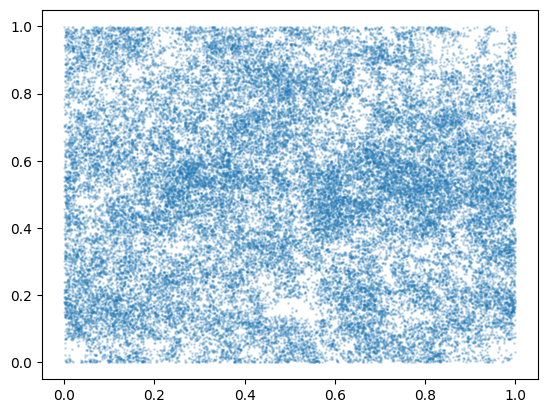

In [15]:
# Create a discrete sample using the PowerBox instance.
samples = pb.create_discrete_sample(nbar=50000,      # nbar specifies the number density
                                    min_at_zero=True  # by default the samples are centred at 0. This shifts them to be positive.
                                   )

# Plot the samples
plt.scatter(samples[:,0],samples[:,1], alpha=0.2,s=1)
plt.show()

In [16]:
# The number of grid points are also required when passing the samples
p_k_samples, bins_samples = pbox.get_power(samples, pb.boxlength,N=pb.N)

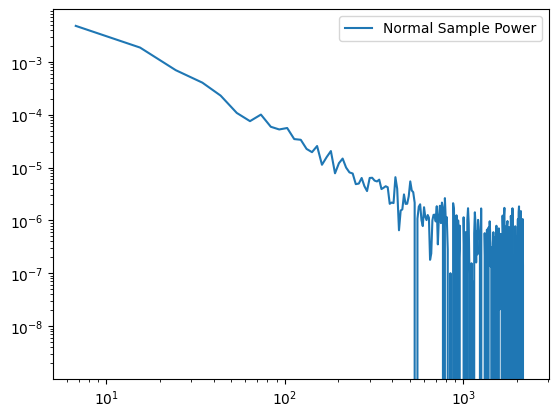

In [17]:
plt.plot(bins_samples, p_k_samples,label="Normal Sample Power")

plt.legend()
plt.xscale('log')
plt.yscale('log')

In [7]:
pb.boxlength

1.0

# Use algorithm

In [18]:
import matplotlib.pyplot as plt
import torch
import tensorflow as tf
import numpy as np
from inverse_optim import gen_data
from inverse_optim import research_plot
from inverse_optim import sancho
import tadasets
import tqdm

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-02-07 22:30:42.953684: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
pb = pbox.PowerBox(
    N=512,                     # Number of grid-points in the box
    dim=2,                     # 2D box
    pk = lambda k: 0.5*k**-2., # The power-spectrum
    boxlength = 1.0,           # Size of the box (sets the units of k in pk)
    seed = 1010,               # Set a seed to ensure the box looks the same every time (optional)
    ensure_physical=True       # ** Ensure the delta_x is a physically valid over-density **
)


# Create a discrete sample using the PowerBox instance.
samples = pb.create_discrete_sample(nbar=5000,      # nbar specifies the number density
                                    min_at_zero=True  # by default the samples are centred at 0. This shifts them to be positive.
                                   )

pts = samples
samples = torch.tensor(samples)


 16%|█▋        | 99/600 [00:21<01:31,  5.47it/s]

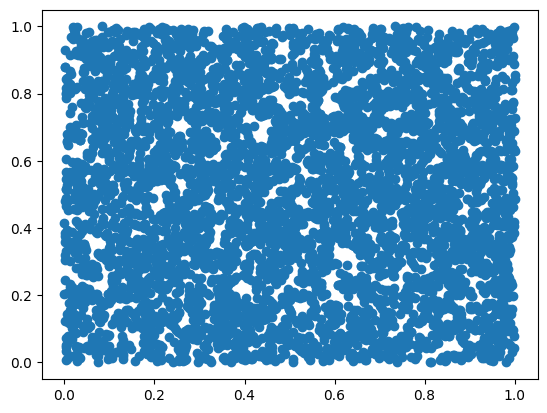

 33%|███▎      | 199/600 [00:44<01:20,  5.00it/s]

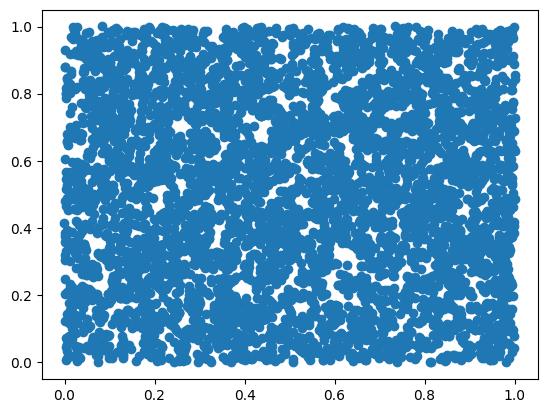

 50%|████▉     | 299/600 [01:04<00:50,  5.94it/s]

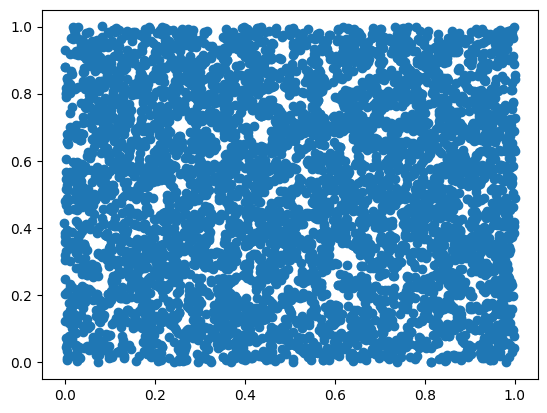

 66%|██████▋   | 399/600 [01:23<00:34,  5.77it/s]

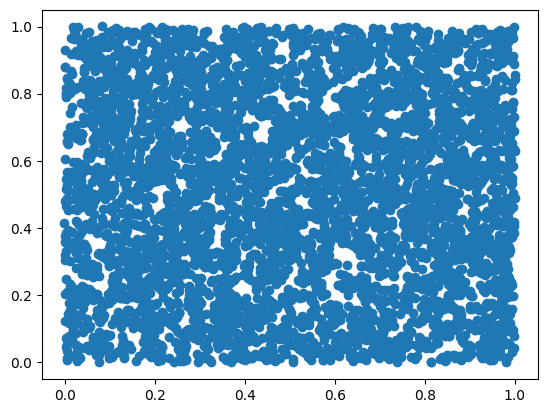

 83%|████████▎ | 499/600 [01:41<00:18,  5.51it/s]

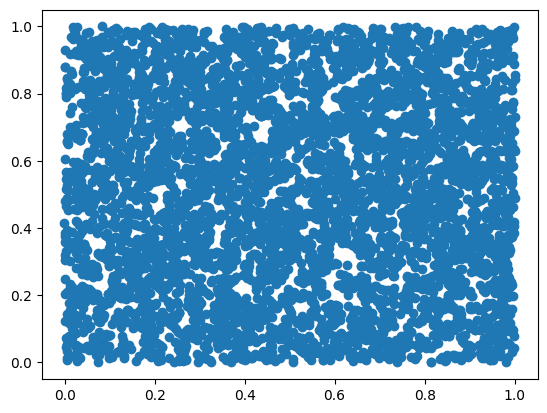

100%|█████████▉| 599/600 [02:00<00:00,  4.77it/s]

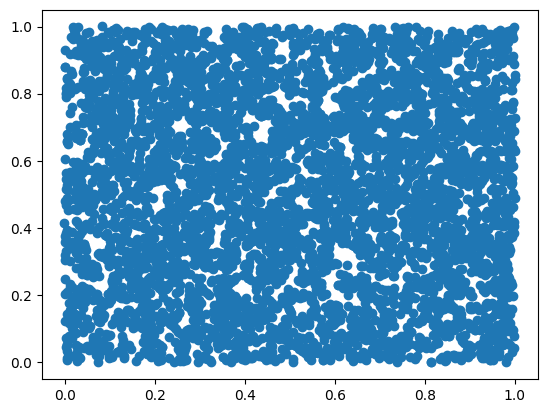

100%|██████████| 600/600 [02:00<00:00,  4.97it/s]


In [21]:
# Creation of the PD that we want to get to
goal_pd = gen_data.create_alpha_pd(samples)

# Generation of new dataset
final_pts = gen_data.generate_data_alpha(goal_pd=goal_pd, amount=samples.size(dim=0), dim=2, lr=0.002, epochs=600, decay_speed=10, investigate=False, sliced=True)


In [45]:
# Research on optimal learning rate
lr_list = np.linspace(0.0001, 0.005, 3)
research_plot.research_lr(lr_list=lr_list, goal_pd=goal_pd, amount=samples.size(dim=0), dim=2, epochs=100, decay_speed=10, sliced=False)

  2%|▏         | 2/100 [00:20<16:36, 10.17s/it]


KeyboardInterrupt: 

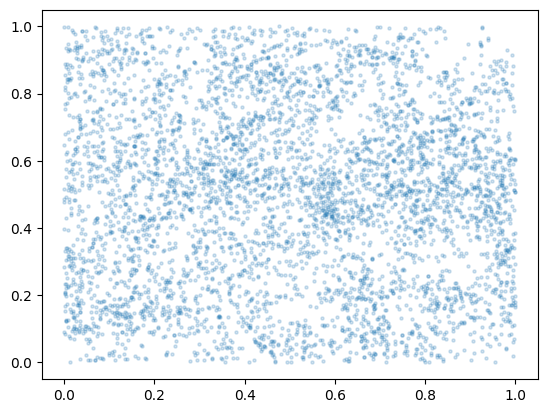

In [22]:
plt.scatter(pts[:,0], pts[:, 1], alpha=0.2, s=5)


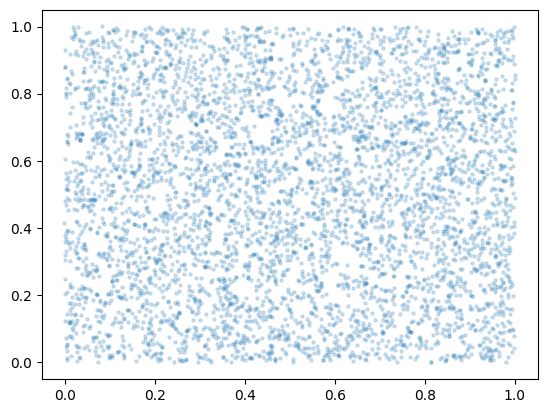

In [23]:
P_new = final_pts.detach().numpy()
plt.scatter(P_new[:,0], P_new[:, 1], alpha=0.2, s=5)

In [26]:
# The number of grid points are also required when passing the samples
p_k_samples, bins_samples = pbox.get_power(pts, pb.boxlength, N=pb.N)
p_k_samples_new, bins_samples_new = pbox.get_power(P_new, pb.boxlength, N=pb.N)

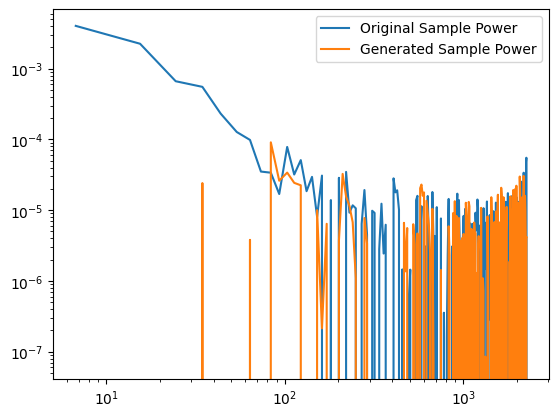

In [27]:
plt.plot(bins_samples, p_k_samples,label="Original Sample Power")
plt.plot(bins_samples_new, p_k_samples_new,label="Generated Sample Power")

plt.legend()
plt.xscale('log')
plt.yscale('log')

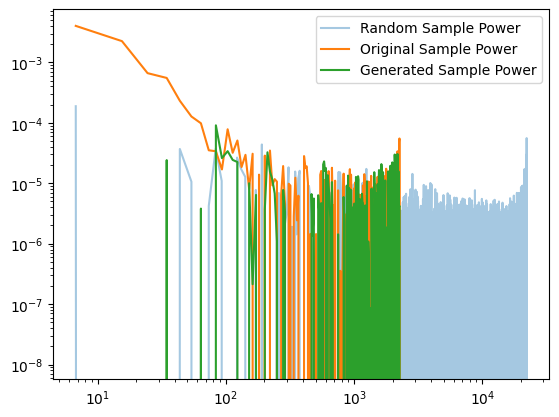

In [29]:
test_pts = np.random.random((samples.size(dim=0), 2))
p_k_samples_test, bins_samples_test = pbox.get_power(test_pts, 1.0, N=samples.size(dim=0))
plt.plot(bins_samples_test, p_k_samples_test,label="Random Sample Power", alpha=0.4)
plt.plot(bins_samples, p_k_samples,label="Original Sample Power")
plt.plot(bins_samples_new, p_k_samples_new,label="Generated Sample Power")

plt.legend()
plt.xscale('log')
plt.yscale('log')